In [47]:
# Add scripts directory to sys.path to import marc21_countries
import sys
import os
sys.path.append(os.path.abspath('/home/msds2025/jvalera/bdcc2025/bdcc-lab-openlib/scripts'))

# All imports
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, explode, concat, lit, regexp_replace, regexp_extract, when, floor, row_number, broadcast, collect_list, lower, array_distinct
from pyspark.sql.types import StringType, ArrayType, StructType, StructField, IntegerType
from pyspark.sql.window import Window

from pyspark.sql.functions import udf
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

import pandas as pd

from marc21_countries import country_mapping

import nltk
from nltk.corpus import stopwords
import re

In [ ]:
# # Download NLTK resources
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')

In [2]:
# Define custom palette
denver_palette = ['#DBEFBC', '#AEC1D7', '#8093F1', '#72DDF7', '#E8AEB7', '#FAA381']
sns.set_palette(denver_palette)

# Define custom colormap for heatmap
colors = ['#DBEFBC', '#DFDFBB', '#E2CFBA', '#E5BFB9', '#E8AEB7']  
denver_cmap = mcolors.LinearSegmentedColormap.from_list("denver_cmap", colors)

[nltk_data] Downloading package punkt to
[nltk_data]     /home/msds2025/jvalera/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/msds2025/jvalera/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/msds2025/jvalera/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
os.getcwd()

'/home/msds2025/jvalera/bdcc2025/bdcc-lab-openlib/notebooks'

In [4]:
# Initialize Spark session
spark = (SparkSession
         .builder
         .appName("Optimized EDA for 136M Rows")
         .master("local[*]")
         .config("spark.driver.memory", "16g")
         .config("spark.driver.maxResultSize", "2g")
         .config("spark.executor.memory", "8g")
         .config("spark.executor.cores", "4")
         .config("spark.sql.shuffle.partitions", "800")
         .config("spark.default.parallelism", "800")
         .config("spark.sql.adaptive.enabled", "true")
         .config("spark.memory.offHeap.enabled", "true")
         .config("spark.memory.offHeap.size", "4g")
         .config("spark.sql.autoBroadcastJoinThreshold", "-1")
         .getOrCreate()
        )

# Load partitioned DataFrames

In [5]:
eds_output_path = "/home/msds2025/jvalera/bdcc2025/bdcc-lab-openlib/partitioned_data/eds_partitioned"
# works_output_path = "/home/msds2025/jvalera/bdcc2025/bdcc-lab-openlib/partitioned_data/works_partitioned"
authors_output_path = "/home/msds2025/jvalera/bdcc2025/bdcc-lab-openlib/partitioned_data/authors_partitioned"

df_eds_final = spark.read.parquet(eds_output_path)
# df_works_final = spark.read.parquet(works_output_path)
df_authors_final = spark.read.parquet(authors_output_path).select("author_key", "name").distinct()


In [6]:
# Inspect schemas
df_eds_final.printSchema()
# df_works_final.printSchema()
df_authors_final.printSchema()

root
 |-- record_type: string (nullable = true)
 |-- edition_key: string (nullable = true)
 |-- title: string (nullable = true)
 |-- subtitle: string (nullable = true)
 |-- author_keys: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- work_keys: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- key: string (nullable = true)
 |-- language_keys: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- publish_country: string (nullable = true)
 |-- publish_date: string (nullable = true)
 |-- publish_places: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- genres: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- subjects: array (nullable = true)
 |    |-- element: string (containsNull = true)

root
 |-- author_key: string (nullable = true)
 |-- name: string (nullable = true)



# Preprocessing

`df_eds1` will be used for:
1. Timeline per Decade
2. Top Countries (all time)
3. Top Subjects (all time)
4. Top Subjects per Top Country (all time)
5. Top Countries per Top Subject (all time)
6. Top Countries per Decade
7. Top Subjects per Decade
8. Top Subjects per Top Country per Decade
    9. Top Countries per Top Subject per Decade

Note: make sure to explode subjects for subject-related tasks

In [7]:
df_eds1 = (df_eds_final
                .withColumn("year", 
                            when(regexp_extract(col("publish_date"), r"(\d{4})", 1) != "",
                                 regexp_extract(col("publish_date"), r"(\d{4})", 1)
                                ).otherwise(None)
                           )
                .withColumn("decade",
                            when(col("year").isNotNull(),
                                 concat((floor(col("year") / 10) * 10).cast("string"), lit("s"))
                                ).otherwise(lit("Unknown"))
                           )
                .filter(col("year").isNotNull() & col("year").between(1900, 2020))
                .withColumn("publish_country",
                            lower(regexp_replace(col("publish_country"), r"^-", ""))
                           )
                .join(broadcast(spark.createDataFrame(list(country_mapping.items()),["publish_country", "country"])),
                      on="publish_country",
                      how="left"
                     )
                .withColumn("country",
                            when(col("country").isNotNull(),
                                 col("country")
                                ).otherwise(lit("Unknown"))
                           )
                .select("decade", "country", "subjects")
               )

In [8]:
df_eds1.columns

['decade', 'country', 'subjects']

In [9]:
lemmatizer = WordNetLemmatizer()

@udf(returnType=StringType())
def clean_text(text):
    if text is None:
        return ''
    # lowercase
    text = text.lower()
    # replace slashes with space
    text = re.sub(r'/', ' ', text)
    # keep alphanumerics
    text = re.sub(r'[^a-z0-9\s]', '', text)
    # normalize whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    # tokenize
    tokens = word_tokenize(text)
    return ' '.join(tokens)

In [10]:
df_exploded_cleaned = (df_eds1
                       .withColumn("subject", explode(col("subjects")))
                       .filter(col("subject").isNotNull())
                       .withColumn("clean_subject", clean_text(col("subject")))
                       .select("decade", "country", "clean_subject")
                      )

In [12]:
os.chdir('/home/msds2025/jvalera/bdcc2025/bdcc-lab-openlib/')
output_dir = os.path.join(os.getcwd(), "temp_data")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
output_path = f"{output_dir}/subjects_exploded"
df_exploded_cleaned.write.parquet(output_path, mode="overwrite")


In [15]:
df_subs1 = spark.read.parquet(output_path)

In [16]:
df_subs1.columns

['decade', 'country', 'clean_subject']

# Descriptives

# 1. Timeline of Editions by Decade (1900-2025)

In [15]:
# print(f"Total Number of Publications from 1900-2025: {df_eds1.count():,}")

In [16]:
# df_decade_counts = (df_eds1
#                     .groupBy("decade")
#                     .count()
#                     .orderBy("decade")
#                     .toPandas()
#                    )

In [17]:
# df_decade_counts

In [18]:
# # Plot Timeline
# plt.figure(figsize=(12, 6))
# sns.barplot(x="decade", y="count", data=df_decade_counts, color="#8093F1")
# plt.title("Editions Published per Decade (1900–2025)")
# plt.xlabel("Decades")
# plt.ylabel("Number of Publications")
# # plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()
# plt.savefig("/home/msds2025/jvalera/bdcc2025/bdcc-lab-openlib/plots/decade_counts.png")

# 2. Countries with the Most Publications (1900-2025)

In [19]:
# df_country_counts = (df_eds1
#                      .filter(col("country") != "Unknown")
#                      .withColumn("country",
#                                  when(col("country") == "United States of America", "USA")
#                                  .when(col("country") == "United Kingdom", "UK")
#                                  .otherwise(col("country")))
#                      .groupBy("country")
#                      .count()
#                      .orderBy(desc("count"))
#                      .limit(20)
#                      .toPandas()
#                     )

In [20]:
# df_country_counts

In [21]:
# # Plot Top Countries
# plt.figure(figsize=(12, 6))
# sns.barplot(x="country", y="count", data=df_country_counts, color="#8093F1")
# plt.title("Top 20 Countries with Most Publications (1900–2025)")
# plt.xlabel("Countries")
# plt.ylabel("Number of Publications")
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()
# plt.savefig("/home/msds2025/jvalera/bdcc2025/bdcc-lab-openlib/plots/country_counts.png")

In [22]:
"""Just for fun, here's the full list! Uncomment if you're bored!"""

# df_country_counts_full = (df_eds1
#                      .filter(col("country") != "Unknown")
#                      .withColumn("country",
#                                  when(col("country") == "United States of America", "USA")
#                                  .when(col("country") == "United Kingdom", "UK")
#                                  .otherwise(col("country")))
#                      .groupBy("country")
#                      .count()
#                      .orderBy(col("count").desc())
#                      .toPandas()
#                     )
# df_country_counts_full.to_csv("/home/msds2025/jvalera/bdcc2025/bdcc-lab-openlib/extras/full_country_counts.csv", index=False)


"Just for fun, here's the full list! Uncomment if you're bored!"

# 3. Top Subjects Globally (1900-2025)

In [17]:
subject_counts = (df_subs1
                  .groupby("clean_subject")
                  .count()
                  .orderBy(col("count").desc())
                  .limit(20)
                  .toPandas()
                 )

In [18]:
subject_counts

,clean_subject,count
0,general,4357785
1,fiction,3701833
2,history,2841551
3,fiction general,1451210
4,biography autobiography,1344455
5,business economics,1311488
6,religion,1094968
7,juvenile fiction,1029859
8,united states,1024995
9,biography,971659


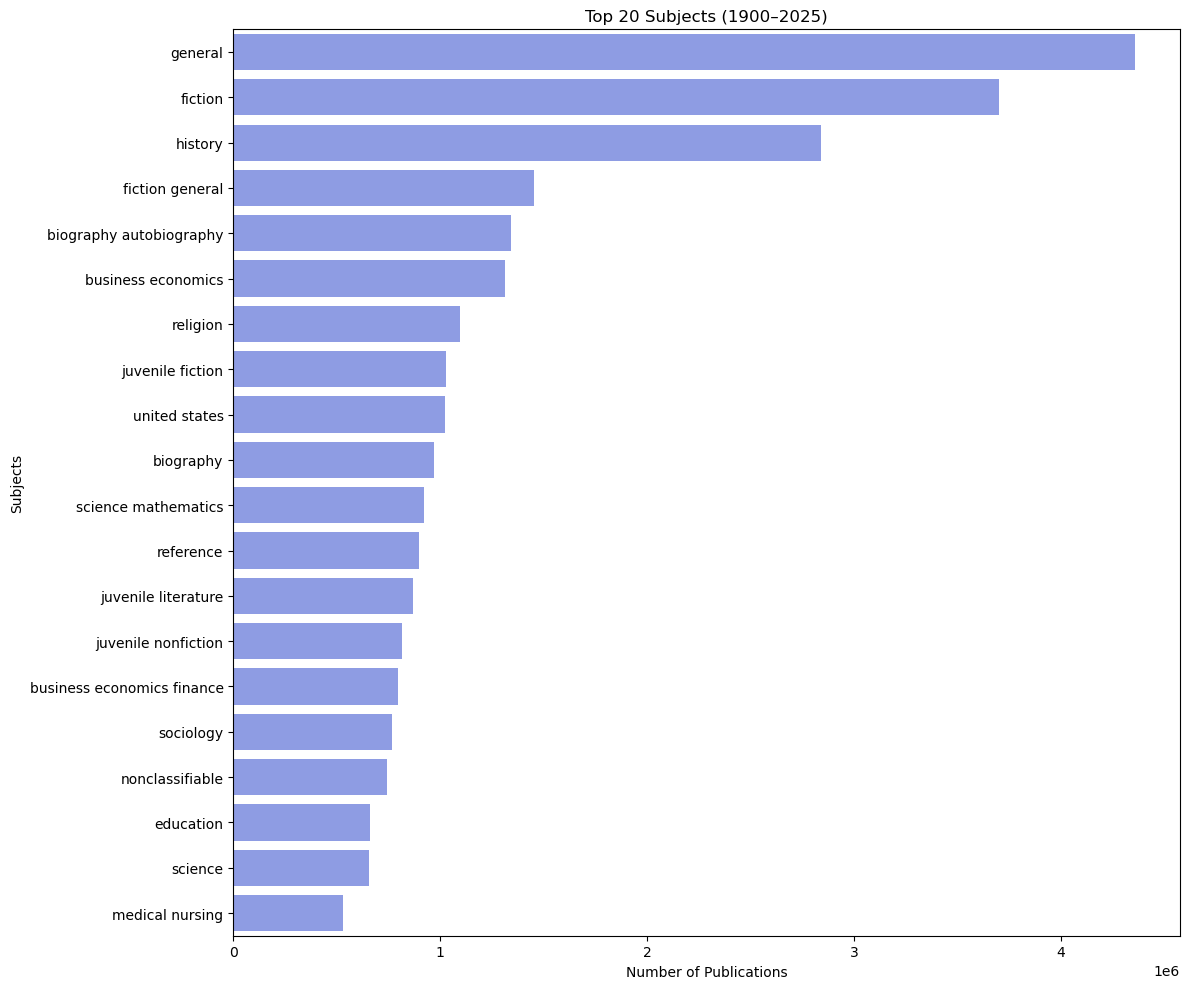

In [24]:
# Plot Subjects Countries
plt.figure(figsize=(12, 10))
sns.barplot(x="count", y="clean_subject", data=subject_counts, color="#8093F1")
plt.title("Top 20 Subjects (1900–2025)")
plt.xlabel("Number of Publications")
plt.ylabel("Subjects")
# plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("/home/msds2025/jvalera/bdcc2025/bdcc-lab-openlib/plots/subject_counts.png")
plt.show()

# 4. Top Subjects per Decade

In [28]:
pd.set_option("display.max_colwidth",None)
pd.set_option("display.max_columns",None)
pd.set_option("display.max_rows",None)

In [33]:
top_10_per_decade = (df_subs1
                     .groupBy("decade", "clean_subject")
                     .count()
                     .withColumn("rank", row_number().over(Window.partitionBy("decade").orderBy(col("count").desc())))
                     .filter(col("rank") <= 10)
                     .orderBy(col("decade").asc())
                     .toPandas()
                    )

In [34]:
top_10_per_decade

,decade,clean_subject,count,rank
0,1900s,united states claims,84103,1
1,1900s,bills private united states,84076,2
2,1900s,united states congress private bills,84067,3
3,1900s,history,22011,4
4,1900s,catalogs,10001,5
5,1900s,periodicals,5891,6
6,1900s,public health,5233,7
7,1900s,bible,5193,8
8,1900s,sanitation,5050,9
9,1900s,water supply,4511,10


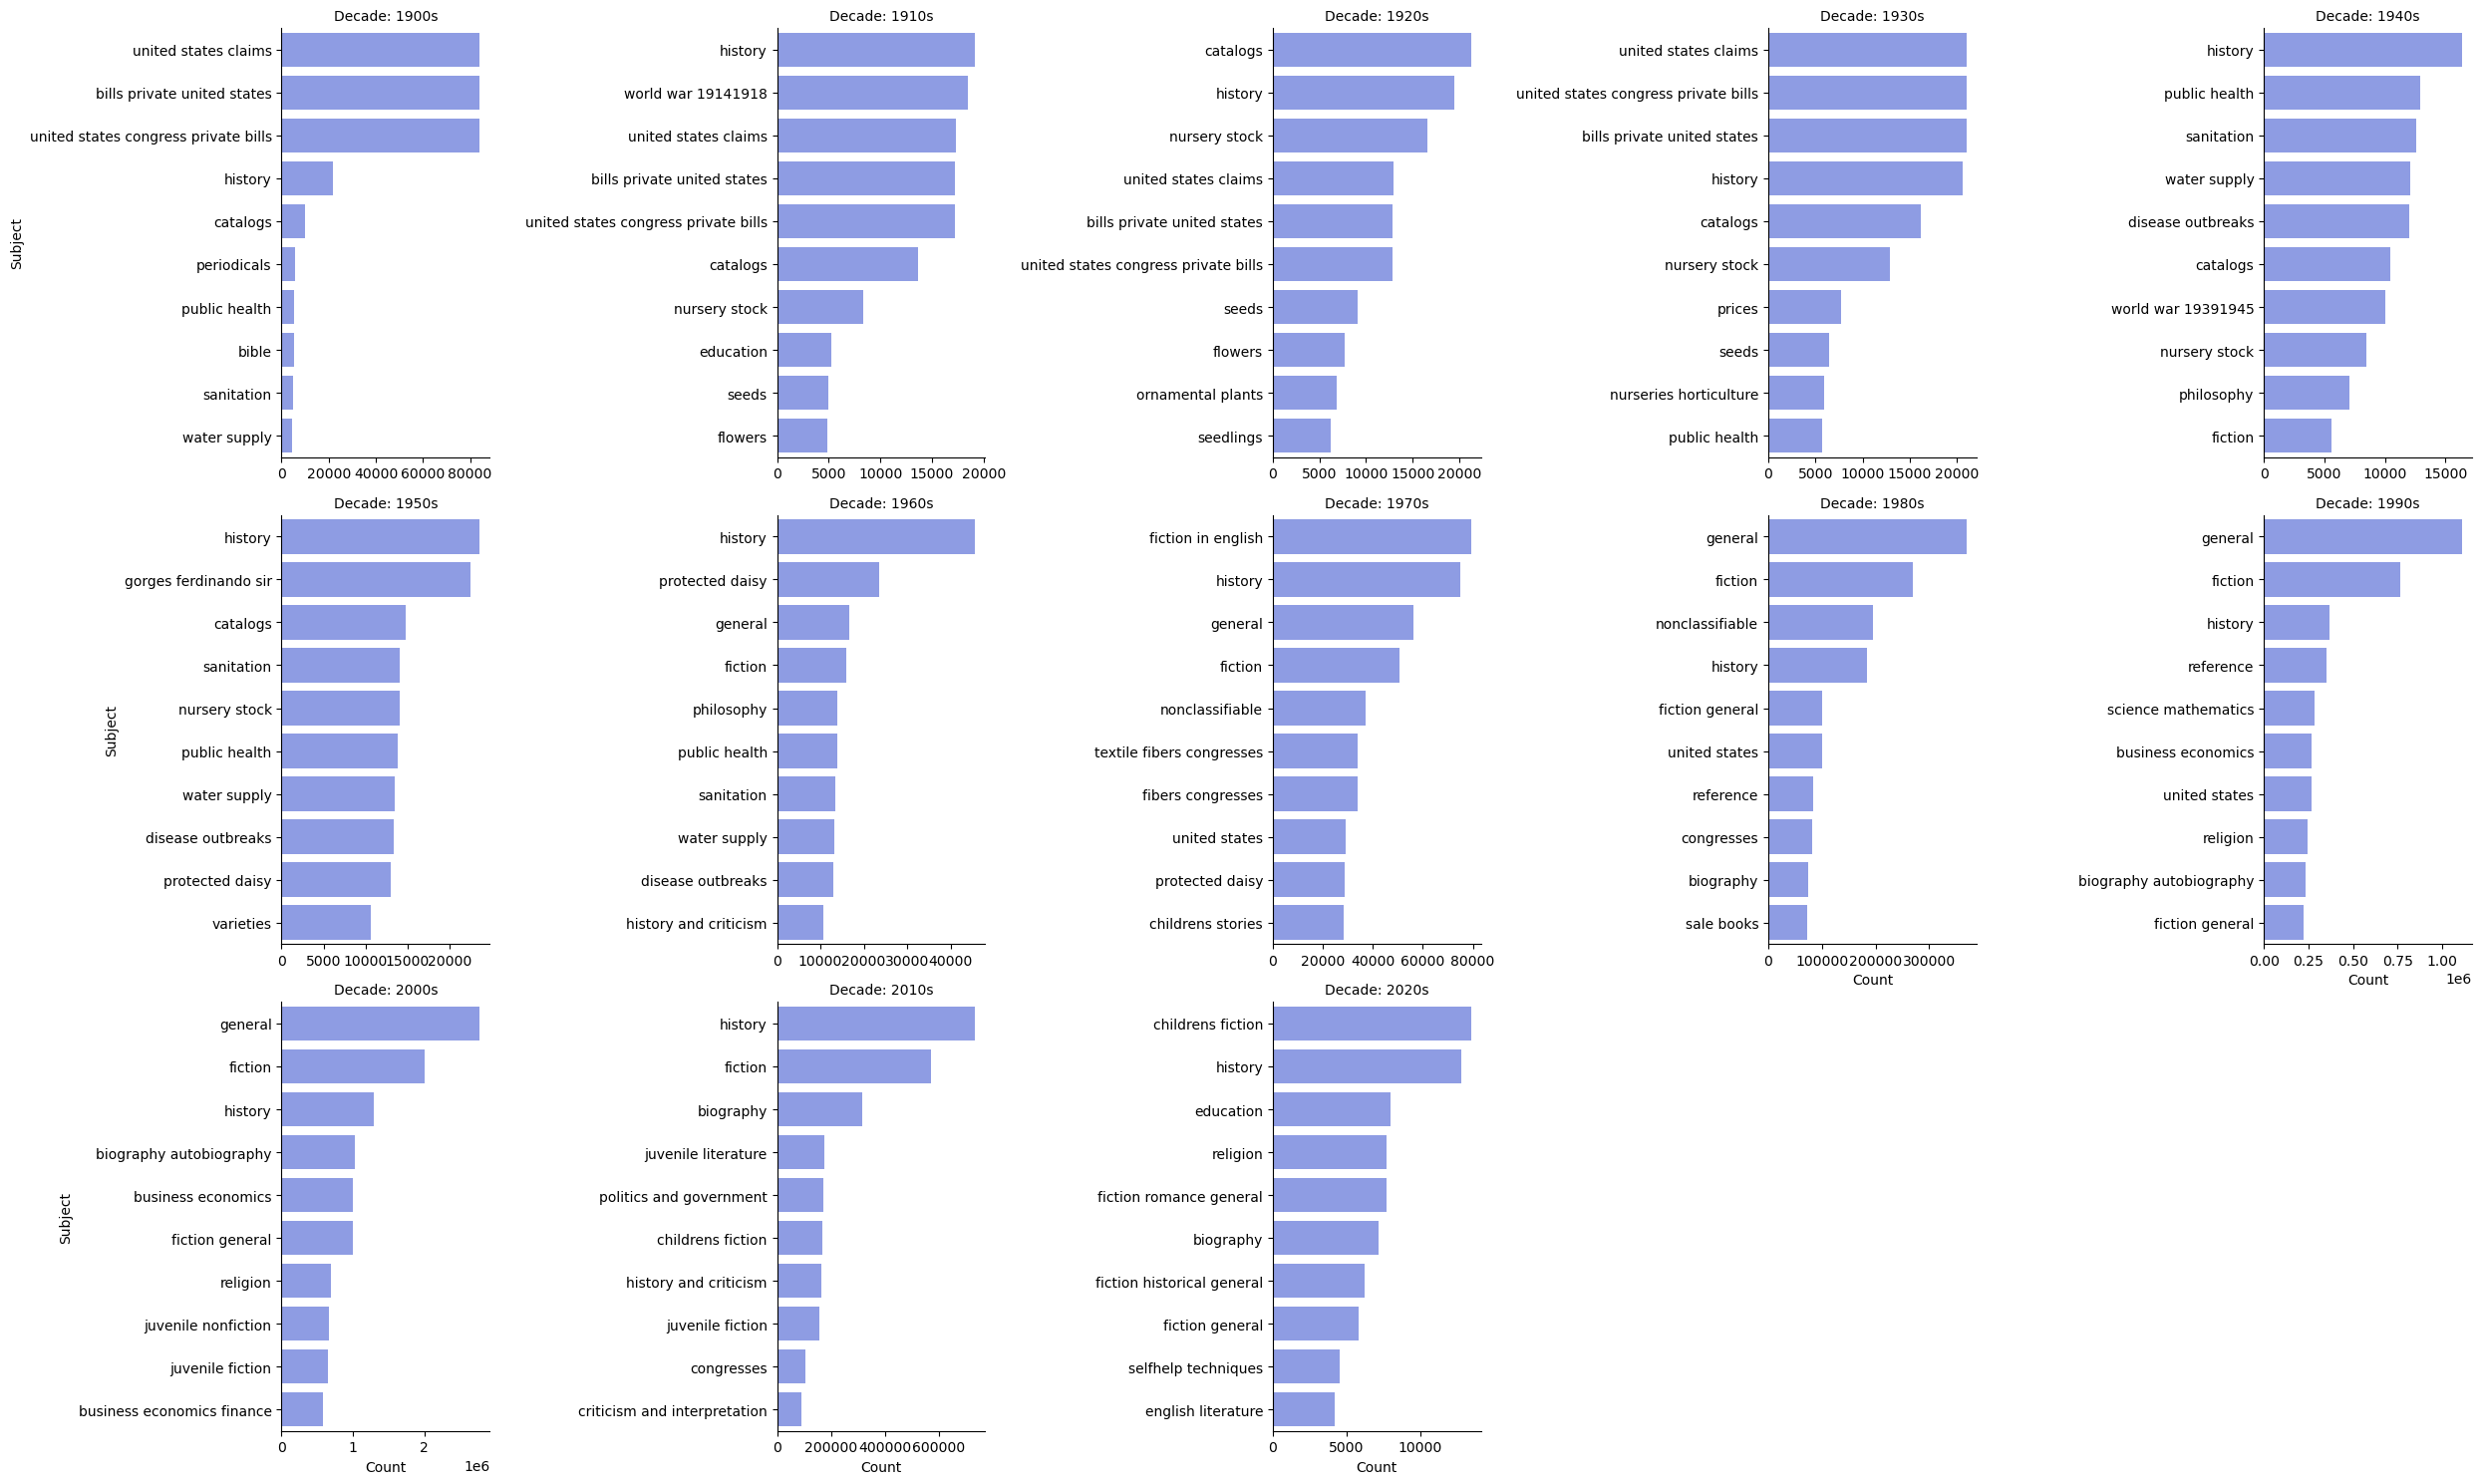

In [46]:
g = sns.FacetGrid(top_10_per_decade_sorted,
                  col="decade",
                  col_wrap=5,
                  height=5,
                  sharey=False,
                  sharex=False,
                 )

g.map_dataframe(sns.barplot, y="clean_subject", x="count", order=None, color="#8093F1")
g.set_titles("Decade: {col_name}")
g.set_axis_labels("Count", "Subject")
g.tight_layout()
plt.show()

# 5. Top 10 Subjects in the Top Country Contributors

In [59]:
# Get top 5 countries as a list
top_10_countries_df = (df_eds1
                      .filter(col("country") != "Unknown")
                      .withColumn("country",
                                  when(col("country") == "United States of America", "USA")
                                  .when(col("country") == "United Kingdom", "UK")
                                  .otherwise(col("country")))
                      .groupBy("country")
                      .count()
                      .withColumn("country_rank", row_number().over(Window.orderBy(col("count").desc())))
                      .filter(col("country_rank") <= 10)
                      .select("country", "country_rank"))

In [60]:
# Extract top 5 countries list for filtering
top_10_countries_list = top_10_countries_df.select("country").toPandas()["country"].tolist()

In [61]:
# Get top 10 subjects per top 5 countries using df_subs, sorted by country rank
top_10_subjects_per_country = (df_subs1
                               .filter(col("country") != "Unknown")
                               .withColumn("country",
                                           when(col("country") == "United States of America", "USA")
                                           .when(col("country") == "United Kingdom", "UK")
                                           .otherwise(col("country")))
                               .filter(col("country").isin(top_10_countries_list))
                               .groupBy("country", "clean_subject")
                               .count()
                               .withColumn("rank", row_number().over(Window.partitionBy("country").orderBy(col("count").desc())))
                               .filter(col("rank") <= 10)
                               .join(top_10_countries_df.select("country", "country_rank"), "country")
                               .orderBy("country_rank", col("count").desc())
                               .toPandas())

In [62]:
top_10_subjects_per_country

,country,clean_subject,count,rank,country_rank
0,USA,fiction,537698,1,1
1,USA,history,304589,2,1
2,USA,large type books,234889,3,1
3,USA,protected daisy,211574,4,1
4,USA,juvenile literature,191862,5,1
5,USA,biography,170422,6,1
6,USA,juvenile fiction,150028,7,1
7,USA,united states claims,136066,8,1
8,USA,bills private united states,135217,9,1
9,USA,united states congress private bills,135164,10,1


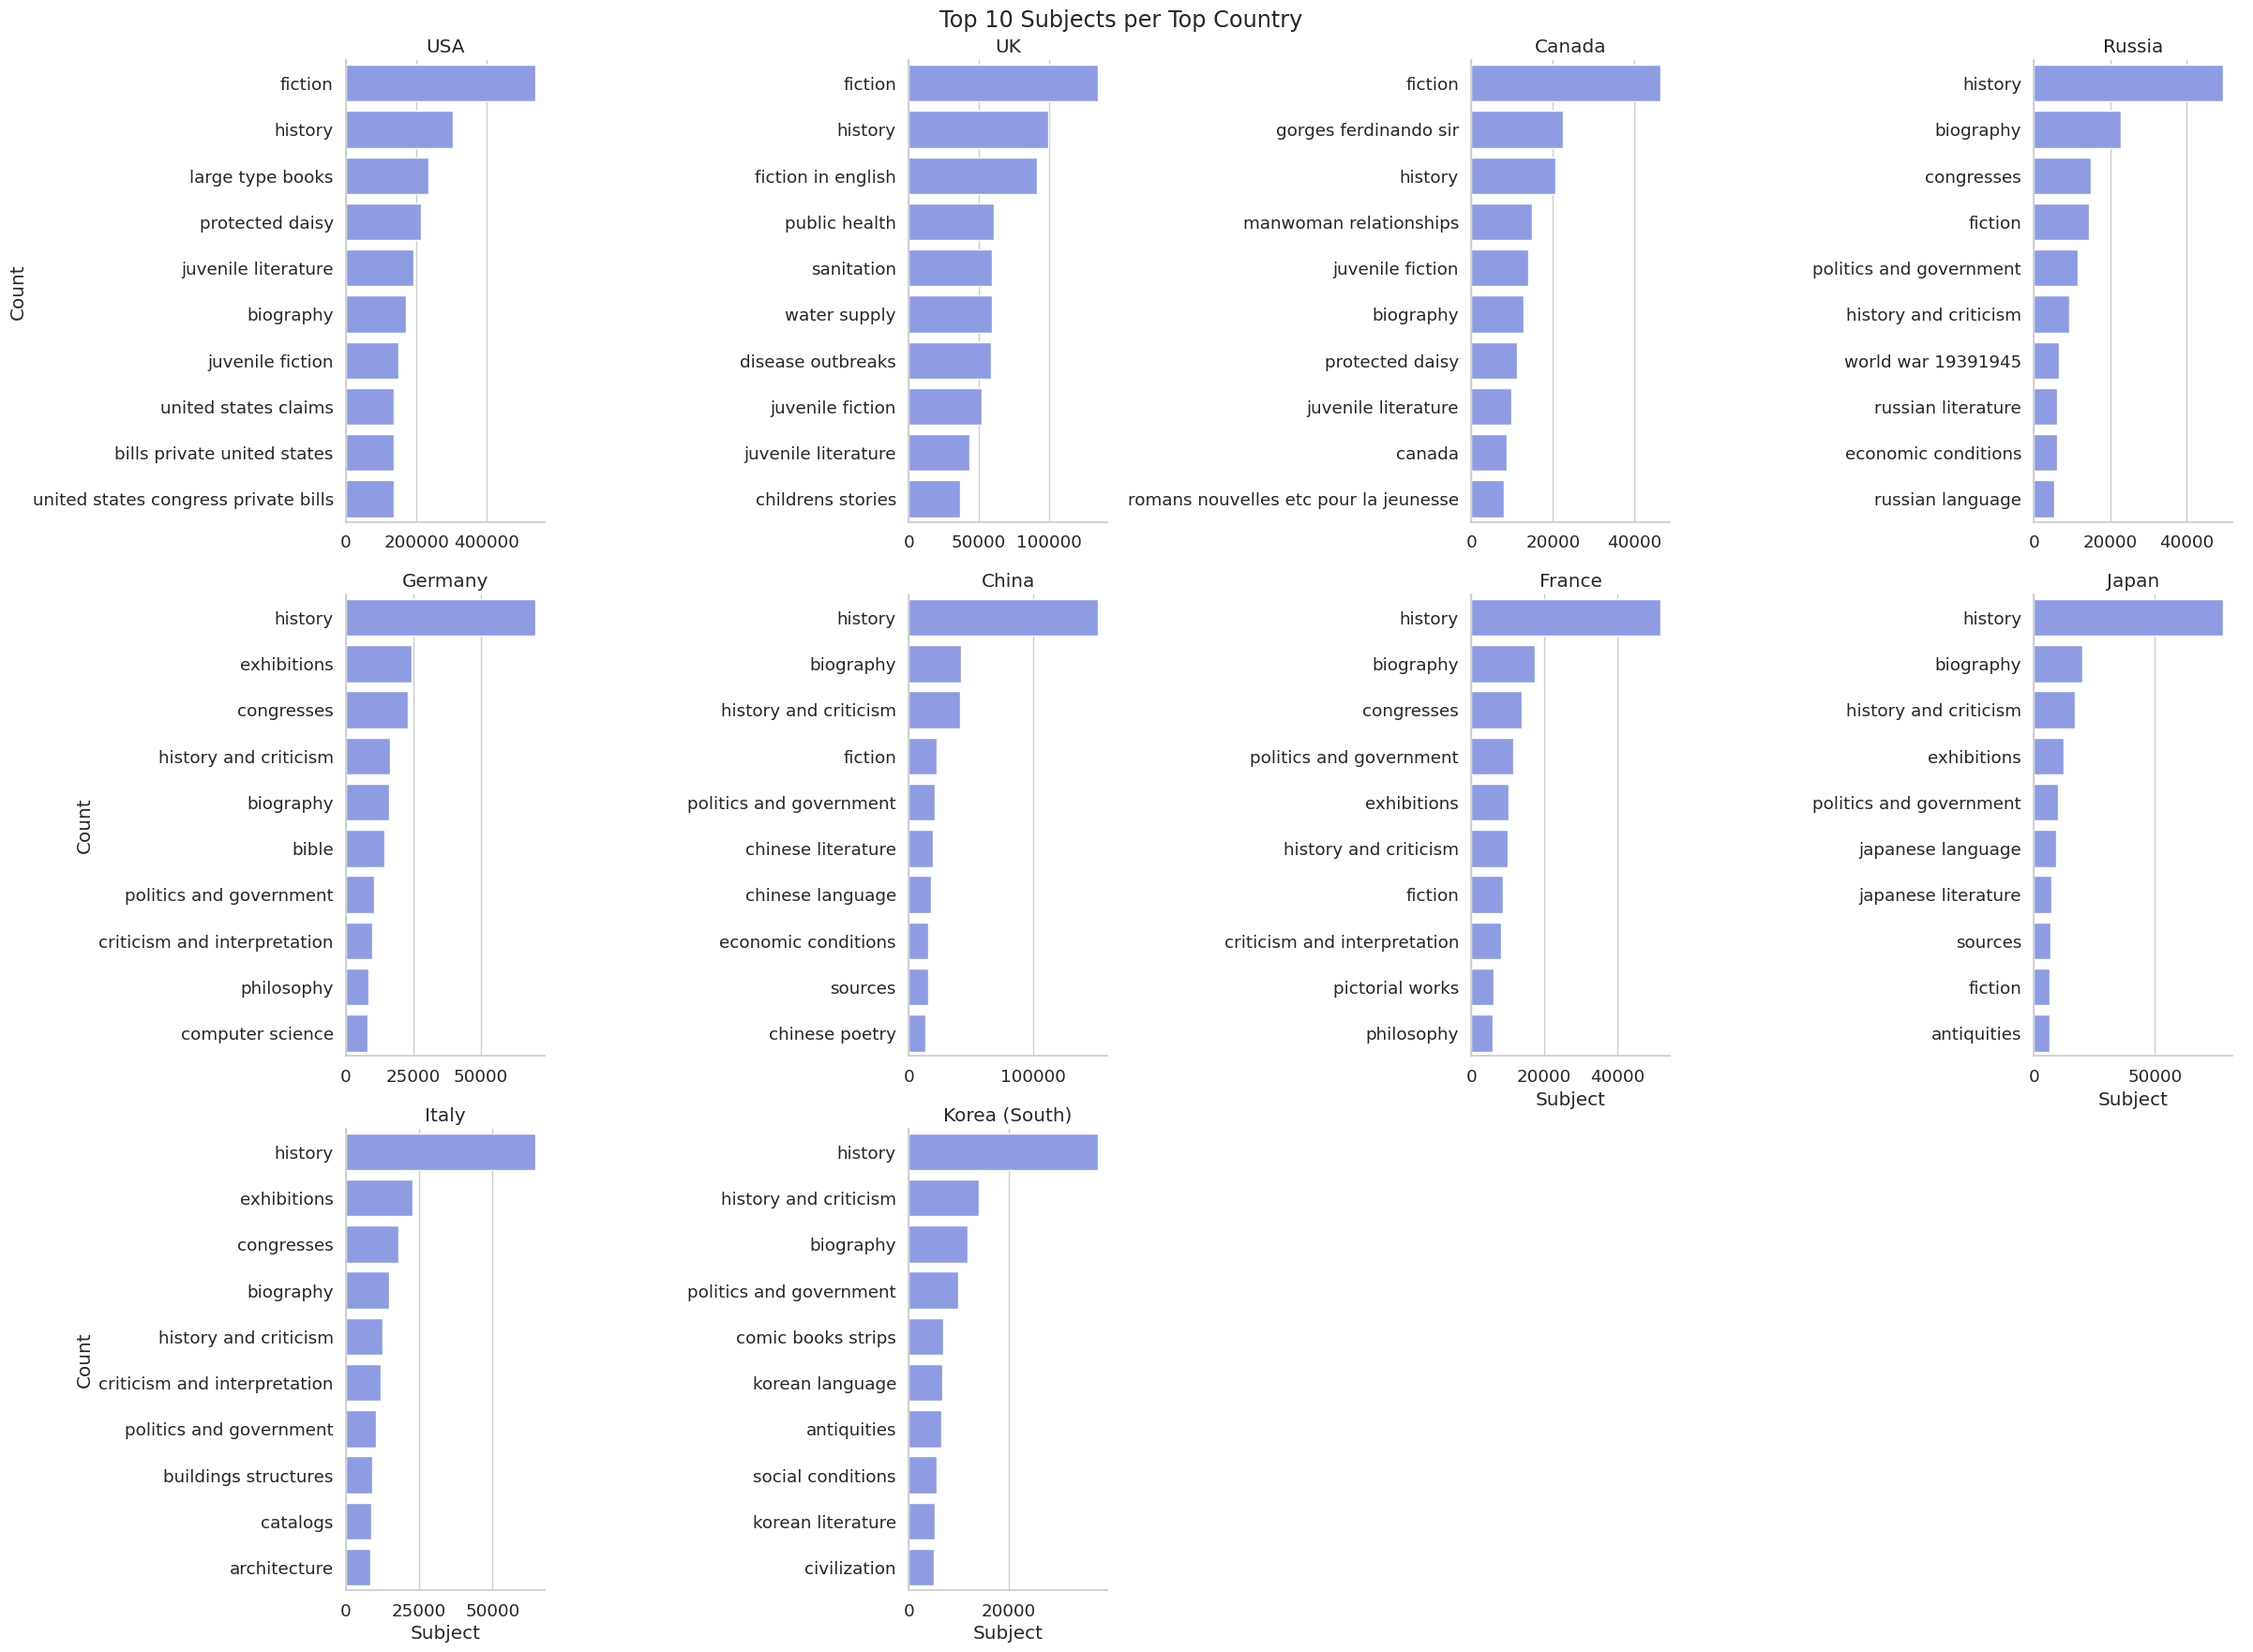

In [64]:
# Set Seaborn style for better aesthetics
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.2)

# Create a faceted bar plot
g = sns.catplot(
    data=top_10_subjects_per_country,
    x="count",
    y="clean_subject",
    col="country",
    col_wrap=4,  # Adjust to fit 5 countries (3 columns, 2 rows)
    kind="bar",
    height=6,
    sharex=False,
    sharey=False,
    color="#8093F1"
)

# Customize the plot
g.set_axis_labels("Subject", "Count")
g.set_titles("{col_name}")
g.fig.suptitle("Top 10 Subjects per Top Country")

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, explode, explode_outer, split, count, array_contains, udf, flatten, collect_list, when, array, collect_set, row_number, desc, regexp_replace, lower, lit
from pyspark.sql.window import Window
import re
import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pyspark.sql.types import ArrayType, StringType

# Download necessary NLTK resources
nltk.download('wordnet')
nltk.download('stopwords')

# Initialize SparkSession with increased memory settings
spark = SparkSession.builder \
    .appName("SubjectAnalysis") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.sql.shuffle.partitions", "200") \
    .getOrCreate()

# Assuming the data is in a format like:
# | decade | country | subjects                  |
# |--------|---------|---------------------------|
# | 1980   | USA     | ["science", "technology"] |
# | 1990   | Canada  | ["history", "art"]        |

# Path to your data
data_path = "your_data_path.csv"  # Update this path

# Load the data
df = spark.read.csv(data_path, header=True, sep=",")

# If subjects are stored as strings, convert to arrays
if not isinstance(df.schema["subjects"].dataType, ArrayType):
    df = df.withColumn("subjects", split(col("subjects"), ","))

# Define cleaning function with lemmatization and stemming
def clean_subjects(subjects_list):
    if subjects_list is None:
        return []
    
    lemmatizer = WordNetLemmatizer()
    stemmer = PorterStemmer()
    stop_words = set(stopwords.words('english'))
    
    cleaned_subjects = []
    for subject in subjects_list:
        if subject is None:
            continue
        
        # Convert to lowercase and remove non-alphanumeric characters
        subject = re.sub(r'[^a-zA-Z0-9\s]', '', subject.lower())
        
        # Split compound subjects and process each part
        parts = subject.split()
        parts = [word for word in parts if word not in stop_words]
        
        # Apply lemmatization and stemming
        parts = [stemmer.stem(lemmatizer.lemmatize(word)) for word in parts]
        
        # Rejoin if it was a compound subject
        if parts:
            cleaned_subjects.append(" ".join(parts))
    
    return cleaned_subjects

# Register UDF
clean_subjects_udf = udf(clean_subjects, ArrayType(StringType()))

# Clean the subjects
df_cleaned = df.withColumn("cleaned_subjects", clean_subjects_udf(col("subjects")))

# Cache the cleaned dataframe to improve performance for multiple queries
df_cleaned.cache()

# Save the cleaned data to a parquet file for future use (optional)
df_cleaned.write.mode("overwrite").parquet("cleaned_subjects_data.parquet")

# 1. Top subjects overall (without exploding)
def get_top_subjects(n=20):
    print(f"Getting top {n} subjects overall...")
    
    # Count subjects by using array_contains instead of explode
    all_subjects = df_cleaned.select("cleaned_subjects").rdd.flatMap(lambda x: x[0] if x[0] else []).collect()
    
    # Use Python collections to count instead of exploding in Spark
    from collections import Counter
    subject_counts = Counter(all_subjects)
    
    # Convert to DataFrame
    top_subjects_df = pd.DataFrame.from_dict(subject_counts, orient='index').reset_index()
    top_subjects_df.columns = ['subject', 'count']
    top_subjects_df = top_subjects_df.sort_values('count', ascending=False).head(n)
    
    return top_subjects_df

# 2. Top subject per decade
def get_top_subjects_by_decade(n=5):
    print("Getting top subjects by decade...")
    
    # Group by decade first
    decades = df_cleaned.select("decade").distinct().collect()
    
    results = []
    for decade_row in decades:
        decade = decade_row[0]
        decade_data = df_cleaned.filter(col("decade") == decade)
        
        # Extract subjects from the decade
        decade_subjects = decade_data.select("cleaned_subjects").rdd.flatMap(lambda x: x[0] if x[0] else []).collect()
        
        # Count them with Python's Counter
        from collections import Counter
        subject_counts = Counter(decade_subjects)
        
        # Get top N
        top_n = subject_counts.most_common(n)
        
        # Add to results
        for subject, count in top_n:
            results.append((decade, subject, count))
    
    # Convert to DataFrame
    top_by_decade_df = pd.DataFrame(results, columns=['decade', 'subject', 'count'])
    top_by_decade_df = top_by_decade_df.sort_values(['decade', 'count'], ascending=[True, False])
    
    return top_by_decade_df

# 3. Top subject per top country
def get_top_subjects_by_country(n=5, top_countries=20):
    print(f"Getting top {n} subjects for top {top_countries} countries...")
    
    # First get top countries
    country_counts = df_cleaned.groupBy("country").count().orderBy(col("count").desc())
    top_countries_list = [row['country'] for row in country_counts.limit(top_countries).collect()]
    
    results = []
    for country in top_countries_list:
        country_data = df_cleaned.filter(col("country") == country)
        
        # Extract subjects from the country
        country_subjects = country_data.select("cleaned_subjects").rdd.flatMap(lambda x: x[0] if x[0] else []).collect()
        
        # Count them with Python's Counter
        from collections import Counter
        subject_counts = Counter(country_subjects)
        
        # Get top N
        top_n = subject_counts.most_common(n)
        
        # Add to results
        for subject, count in top_n:
            results.append((country, subject, count))
    
    # Convert to DataFrame
    top_by_country_df = pd.DataFrame(results, columns=['country', 'subject', 'count'])
    top_by_country_df = top_by_country_df.sort_values(['country', 'count'], ascending=[True, False])
    
    return top_by_country_df

# 4. Top country per top subject
def get_top_countries_by_subject(n=5, top_subjects=20):
    print(f"Getting top {n} countries for top {top_subjects} subjects...")
    
    # First get top subjects
    all_subjects = df_cleaned.select("cleaned_subjects").rdd.flatMap(lambda x: x[0] if x[0] else []).collect()
    from collections import Counter
    subject_counts = Counter(all_subjects)
    top_subjects_list = [subject for subject, _ in subject_counts.most_common(top_subjects)]
    
    results = []
    for subject in top_subjects_list:
        # Filter rows containing this subject
        subject_data = df_cleaned.filter(array_contains(col("cleaned_subjects"), subject))
        
        # Count by country
        country_counts = subject_data.groupBy("country").count().orderBy(col("count").desc())
        
        # Get top N
        top_n = country_counts.limit(n).collect()
        
        # Add to results
        for row in top_n:
            results.append((subject, row['country'], row['count']))
    
    # Convert to DataFrame
    top_countries_by_subject_df = pd.DataFrame(results, columns=['subject', 'country', 'count'])
    top_countries_by_subject_df = top_countries_by_subject_df.sort_values(['subject', 'count'], ascending=[True, False])
    
    return top_countries_by_subject_df

# 5. Top subject per top country per decade
def get_top_subjects_by_country_decade(n=3, top_countries=10):
    print(f"Getting top {n} subjects by country and decade...")
    
    # First get top countries
    country_counts = df_cleaned.groupBy("country").count().orderBy(col("count").desc())
    top_countries_list = [row['country'] for row in country_counts.limit(top_countries).collect()]
    
    results = []
    for country in top_countries_list:
        country_data = df_cleaned.filter(col("country") == country)
        
        # Get decades for this country
        decades = country_data.select("decade").distinct().collect()
        
        for decade_row in decades:
            decade = decade_row[0]
            decade_country_data = country_data.filter(col("decade") == decade)
            
            # Extract subjects
            subjects = decade_country_data.select("cleaned_subjects").rdd.flatMap(lambda x: x[0] if x[0] else []).collect()
            
            # Count with Counter
            from collections import Counter
            subject_counts = Counter(subjects)
            
            # Get top N
            top_n = subject_counts.most_common(n)
            
            # Add to results
            for subject, count in top_n:
                results.append((country, decade, subject, count))
    
    # Convert to DataFrame
    top_by_country_decade_df = pd.DataFrame(results, columns=['country', 'decade', 'subject', 'count'])
    top_by_country_decade_df = top_by_country_decade_df.sort_values(['country', 'decade', 'count'], ascending=[True, True, False])
    
    return top_by_country_decade_df

# 6. Top country per top subject per decade
def get_top_countries_by_subject_decade(n=3, top_subjects=10):
    print(f"Getting top {n} countries by subject and decade...")
    
    # First get top subjects
    all_subjects = df_cleaned.select("cleaned_subjects").rdd.flatMap(lambda x: x[0] if x[0] else []).collect()
    from collections import Counter
    subject_counts = Counter(all_subjects)
    top_subjects_list = [subject for subject, _ in subject_counts.most_common(top_subjects)]
    
    results = []
    for subject in top_subjects_list:
        # Filter rows containing this subject
        subject_data = df_cleaned.filter(array_contains(col("cleaned_subjects"), subject))
        
        # Get decades for this subject
        decades = subject_data.select("decade").distinct().collect()
        
        for decade_row in decades:
            decade = decade_row[0]
            decade_subject_data = subject_data.filter(col("decade") == decade)
            
            # Count by country
            country_counts = decade_subject_data.groupBy("country").count().orderBy(col("count").desc())
            
            # Get top N
            top_n = country_counts.limit(n).collect()
            
            # Add to results
            for row in top_n:
                results.append((subject, decade, row['country'], row['count']))
    
    # Convert to DataFrame
    top_countries_by_subject_decade_df = pd.DataFrame(results, columns=['subject', 'decade', 'country', 'count'])
    top_countries_by_subject_decade_df = top_countries_by_subject_decade_df.sort_values(['subject', 'decade', 'count'], ascending=[True, True, False])
    
    return top_countries_by_subject_decade_df

# Visualization functions
def visualize_top_subjects(df, title="Top Subjects Overall", max_items=20):
    plt.figure(figsize=(12, 8))
    sns.barplot(x='count', y='subject', data=df.head(max_items))
    plt.title(title)
    plt.tight_layout()
    plt.show()

def visualize_top_by_decade(df, title="Top Subjects by Decade", max_decades=5, max_subjects=5):
    df_plot = df.copy()
    if len(df_plot['decade'].unique()) > max_decades:
        top_decades = df_plot.groupby('decade')['count'].sum().nlargest(max_decades).index
        df_plot = df_plot[df_plot['decade'].isin(top_decades)]
    
    plt.figure(figsize=(14, 10))
    g = sns.catplot(
        data=df_plot,
        kind="bar",
        x="subject", y="count", hue="decade",
        ci=None, palette="dark", alpha=.6, height=6, aspect=2
    )
    g.despine(left=True)
    g.set_axis_labels("Subject", "Count")
    g.legend.set_title("Decade")
    plt.title(title)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

def visualize_top_by_country(df, title="Top Subjects by Country", max_countries=5):
    df_plot = df.copy()
    if len(df_plot['country'].unique()) > max_countries:
        top_countries = df_plot.groupby('country')['count'].sum().nlargest(max_countries).index
        df_plot = df_plot[df_plot['country'].isin(top_countries)]
    
    plt.figure(figsize=(14, 10))
    g = sns.catplot(
        data=df_plot,
        kind="bar",
        x="subject", y="count", hue="country",
        ci=None, palette="dark", alpha=.6, height=6, aspect=2
    )
    g.despine(left=True)
    g.set_axis_labels("Subject", "Count")
    g.legend.set_title("Country")
    plt.title(title)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

def visualize_heatmap(df, x_col, y_col, title="Heatmap", max_x=10, max_y=10):
    df_pivot = df.pivot_table(index=y_col, columns=x_col, values='count', aggfunc='sum')
    
    # Limit to top items if needed
    if df_pivot.shape[0] > max_y:
        df_pivot = df_pivot.iloc[:max_y, :]
    if df_pivot.shape[1] > max_x:
        df_pivot = df_pivot.iloc[:, :max_x]
    
    plt.figure(figsize=(14, 10))
    sns.heatmap(df_pivot, annot=True, fmt="g", cmap="viridis")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Run the analysis
if __name__ == "__main__":
    # Execute all analyses
    print("Starting analysis of 136 million rows...")
    
    # 1. Top subjects overall
    top_subjects_df = get_top_subjects(n=20)
    visualize_top_subjects(top_subjects_df)
    
    # 2. Top subjects by decade
    top_by_decade_df = get_top_subjects_by_decade(n=5)
    visualize_top_by_decade(top_by_decade_df)
    
    # 3. Top subjects by country
    top_by_country_df = get_top_subjects_by_country(n=5)
    visualize_top_by_country(top_by_country_df)
    
    # 4. Top countries by subject
    top_countries_by_subject_df = get_top_countries_by_subject(n=5)
    visualize_top_by_country(top_countries_by_subject_df.rename(columns={'subject': 'country', 'country': 'subject'}))
    
    # 5. Top subjects by country and decade
    top_by_country_decade_df = get_top_subjects_by_country_decade(n=3)
    # For visualization, create a subset focusing on one decade
    if not top_by_country_decade_df.empty:
        most_common_decade = top_by_country_decade_df['decade'].value_counts().index[0]
        decade_subset = top_by_country_decade_df[top_by_country_decade_df['decade'] == most_common_decade]
        visualize_top_by_country(decade_subset, title=f"Top Subjects by Country (Decade: {most_common_decade})")
    
    # 6. Top countries by subject and decade
    top_countries_by_subject_decade_df = get_top_countries_by_subject_decade(n=3)
    # For visualization, create a subset focusing on one decade
    if not top_countries_by_subject_decade_df.empty:
        most_common_decade = top_countries_by_subject_decade_df['decade'].value_counts().index[0]
        decade_subset = top_countries_by_subject_decade_df[top_countries_by_subject_decade_df['decade'] == most_common_decade]
        visualize_top_by_country(decade_subset.rename(columns={'subject': 'country', 'country': 'subject'}), 
                                title=f"Top Countries by Subject (Decade: {most_common_decade})")
    
    # Bonus: Create a heatmap for top subjects vs top countries
    top_subjects = top_subjects_df['subject'].head(10).tolist()
    countries_by_subject = df_cleaned.filter(array_contains(col("cleaned_subjects"), lit(top_subjects[0])))
    top_countries = countries_by_subject.groupBy("country").count().orderBy(col("count").desc()).limit(10)
    top_countries_list = [row['country'] for row in top_countries.collect()]
    
    # Create a dataframe for the heatmap
    heatmap_data = []
    for subject in top_subjects:
        for country in top_countries_list:
            count = df_cleaned.filter(
                (col("country") == country) & array_contains(col("cleaned_subjects"), subject)
            ).count()
            heatmap_data.append((subject, country, count))
    
    heatmap_df = pd.DataFrame(heatmap_data, columns=['subject', 'country', 'count'])
    visualize_heatmap(heatmap_df, 'country', 'subject', "Top Subjects vs Countries Heatmap")
    
    print("Analysis complete!")
    
    # Stop Spark session
    spark.stop()

In [21]:
# subject_counts = (df_cleaned
#                   .select(explode(col("clean_subjects")).alias("subjects"))
#                   .groupby("subjects")
#                   .count()
#                   .orderBy(desc("count"))
#                   .limit(20)
#                   .toPandas()
#                  )

In [22]:
# subject_counts.limit(20).toPandas()

In [23]:
schema = StructType([
    StructField("subject", StringType(), True),
    StructField("count", IntegerType(), True)
])

subject_counts = (
    df_cleaned
    .rdd
    .flatMap(lambda row: [(subject, 1) for subject in row.clean_subjects])
    .toDF(schema)
    .groupBy("subject")
    .count()
    .orderBy(col("count").desc())
)

In [24]:
subject_counts.limit(20).toPandas()

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/usr/local/spark/python/pyspark/errors/exceptions/captured.py", line 247, in deco
    return f(*a, **kw)
           ^^^^^^^^^^^
  File "/usr/local/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/protocol.py", line 326, in get_return_value
    raise Py4JJavaError(
py4j.protocol.Py4JJavaError: <exception str() failed>

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/clientserver.py", line 516, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  

ConnectionRefusedError: [Errno 111] Connection refused

In [ ]:
# subject_counts = (
#     df_eds1_clean.select(explode(col("clean_subjects")).alias("subject"))
#     .groupBy("subject")
#     .agg(count("*").alias("count"))
#     .orderBy(desc("count"))
# )

In [ ]:
# subject

In [ ]:
# top_subjects_per_decade = (
#     df_eds1_clean.select("decade", explode(col("clean_subjects")).alias("subject"))
#     .groupBy("decade", "subject")
#     .agg(count("*").alias("count"))
# )

# w = Window.partitionBy("decade").orderBy(desc("count"))
# top_subjects_per_decade = top_subjects_per_decade.withColumn("rank", row_number().over(w)) \
#     .filter(col("rank") <= 10)

In [ ]:
# top_subjects_per

In [ ]:
# """ Let's clean up the subjects first. """
# spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

# # Initialize NLTK resources
# stop_words = set(stopwords.words('english'))
# lemmatizer = WordNetLemmatizer()

In [ ]:
# @udf(returnType=StringType())
# def clean_subject(subject):
#     if not subject:
#         return None
#     # Lowercase and remove special characters
#     subject = subject.lower()
#     subject = re.sub(r'[^a-z\s]', ' ', subject)
#     # Tokenize
#     tokens = word_tokenize(subject)
#     # Remove stopwords, short tokens, and lemmatize
#     tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words and len(token) >= 3]
#     # Map synonyms
#     tokens = [synonym_map.get(token, token) for token in tokens]
#     # Remove duplicates and join
#     tokens = list(dict.fromkeys(tokens))  # Preserve order
#     return ' '.join(tokens) if tokens else None

In [ ]:
# df_subject_counts = (df_eds1
#                      .withColumn("subject", explode(col("subjects")))
#                      .filter(col("subject").isNotNull())
#                      .withColumn("cleaned_subject", clean_subject(col("subject")))
#                      .filter(col("cleaned_subject").isNotNull())
#                      .groupBy("cleaned_subject")
#                      .count()
#                      .orderBy(col("count").desc())
#                      .limit(50)
#                      .cache()
#                     )